# Forecasting with Dynamic Linear Model (DLM)

Among state space models, Dynamic Linear Model (DLM) are one of the most popular models due to its explainability and ability to incorporate regressors with dynamic coefficients. This notebook introduces a way to construct a vanlia DLM through Pyro and Forecaster modules. In the end, it provides an extension to coefficients priors incorporation.

See also:
- [Forecasting II: state space models](http://pyro.ai/examples/forecasting_ii.html)

#### Summary 
1. data simulation
2. visualization of coefficients and response
3. Standard DLM training and validation
    - posteriors comparison
    - holdout validation
4. DLM with coefficients priors at various time points
    - posteriors comparison
    - holdout validation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.stats import quantile

%matplotlib inline
assert pyro.__version__.startswith('1.4.0')

pyro.enable_validation(True)
pyro.set_rng_seed(20200221)
np.random.seed(2020)

pd.set_option('display.max_rows', 500)
plt.style.use('fivethirtyeight')

## Data Simulation

Assume we have observation $y_t$ at time $t$ such that 
$$y_t = x_t^T \beta_t + \epsilon_t$$
$$\beta_t = \beta_{t-1} + \delta_t$$
where

$x_t$ is a P x 1 vector of regressors at time $t$

$\beta_t$ is a P x 1 vector of latent coefficients at time $t$ following a random walk distribution

$\epsilon$ is the noise at time $t$

We then simulate data in following distribution:
$$x_t \sim \mathcal{N}_p(0, \sigma_x^2)$$
$$\delta_t \sim \mathcal{N}_p(0, \sigma_{\delta}^2)$$
$$\epsilon_t \sim \mathcal{N}(0, \sigma_y^2)$$

In [2]:
# number of predictors, total observations
p = 3
n = 720

# start, train end, test end
T0 = 0            
T1 = n - 30
T2 = n

# initializing coefficients at zeros, simulate all coefficient values
beta0 = torch.from_numpy(np.cumsum(np.random.normal(0, 0.3, n))).unsqueeze(-1)
betas_p = torch.from_numpy(np.cumsum(np.random.normal(0, 0.1, size=(n, p)), axis=0))
betas = torch.cat([beta0, betas_p], dim=-1)

# simulate regressors
covariates = torch.cat(
    [torch.ones(n, 1), torch.from_numpy(np.random.normal(2, 1, size=(n, p)))],
    dim=-1
)
# observation with noise
y = ((covariates * betas).sum(-1) + torch.from_numpy(np.random.normal(0, 0.5, n))).unsqueeze(-1)

## Visualization of response and coefficients

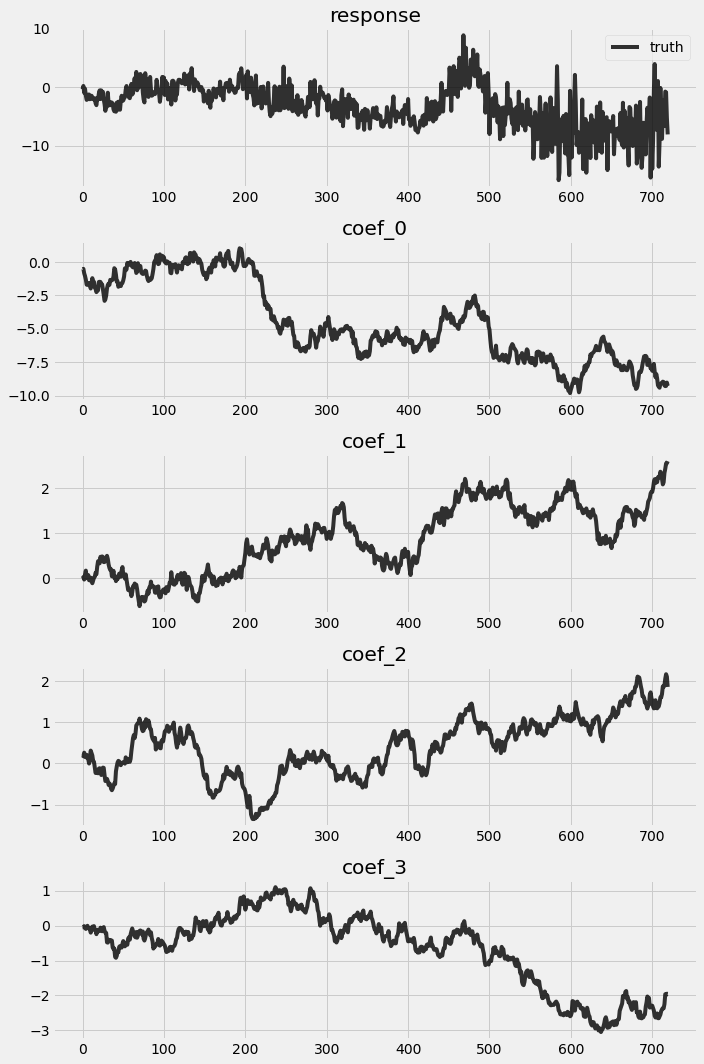

In [3]:
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y, 'k-', label='truth', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

## Train and validate a vanlia DLM

In [4]:
class DLM(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-5, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-10, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)       

In [5]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
forecaster = Forecaster(DLM(), y[:T1], covariates[:T1], learning_rate=0.05, num_steps=3000)

INFO 	 step    0 loss = 4.70345e+17
INFO 	 step  100 loss = 2.65483e+10
INFO 	 step  200 loss = 2.93806e+06
INFO 	 step  300 loss = 140.546
INFO 	 step  400 loss = 10.4351
INFO 	 step  500 loss = 7.07095
INFO 	 step  600 loss = 5.35922
INFO 	 step  700 loss = 4.23932
INFO 	 step  800 loss = 3.89851
INFO 	 step  900 loss = 3.88021
INFO 	 step 1000 loss = 3.17499
INFO 	 step 1100 loss = 2.95644
INFO 	 step 1200 loss = 3.15054
INFO 	 step 1300 loss = 2.87788
INFO 	 step 1400 loss = 3.0833
INFO 	 step 1500 loss = 2.6959
INFO 	 step 1600 loss = 2.60645
INFO 	 step 1700 loss = 2.42491
INFO 	 step 1800 loss = 2.82365
INFO 	 step 1900 loss = 6.71463
INFO 	 step 2000 loss = 2.36883
INFO 	 step 2100 loss = 2.6609
INFO 	 step 2200 loss = 2.86677
INFO 	 step 2300 loss = 2.40096
INFO 	 step 2400 loss = 2.37824
INFO 	 step 2500 loss = 2.19301
INFO 	 step 2600 loss = 2.52023
INFO 	 step 2700 loss = 2.5383
INFO 	 step 2800 loss = 2.56296
INFO 	 step 2900 loss = 2.4021


CPU times: user 21.6 s, sys: 74.6 ms, total: 21.7 s
Wall time: 21.7 s


### Posteriors comparison

We extract posteriors during the in-sample period and compare them against the truth.

In [6]:
num_samples = 100
dim = -2
with torch.no_grad():
    # record the VI samples from the guide
    with poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.guide(y[:T1], covariates[:T1])
    guide_trace = tr.trace

    # replay the model against the posteriors samples
    with poutine.replay(trace=guide_trace), poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.model(y[:T1], covariates[:T1])

    # extract the values from the recorded 
    posterior_samples = {
        name: site["value"]
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    }
    
prediction = posterior_samples["prediction"].median(0).values
posterior_weight_mean = posterior_samples['weight'].median(0).values

In [7]:
forecaster.guide()['drift_scale']

tensor([0.0911, 0.0200, 0.0018, 0.0228], grad_fn=<ExpandBackward>)

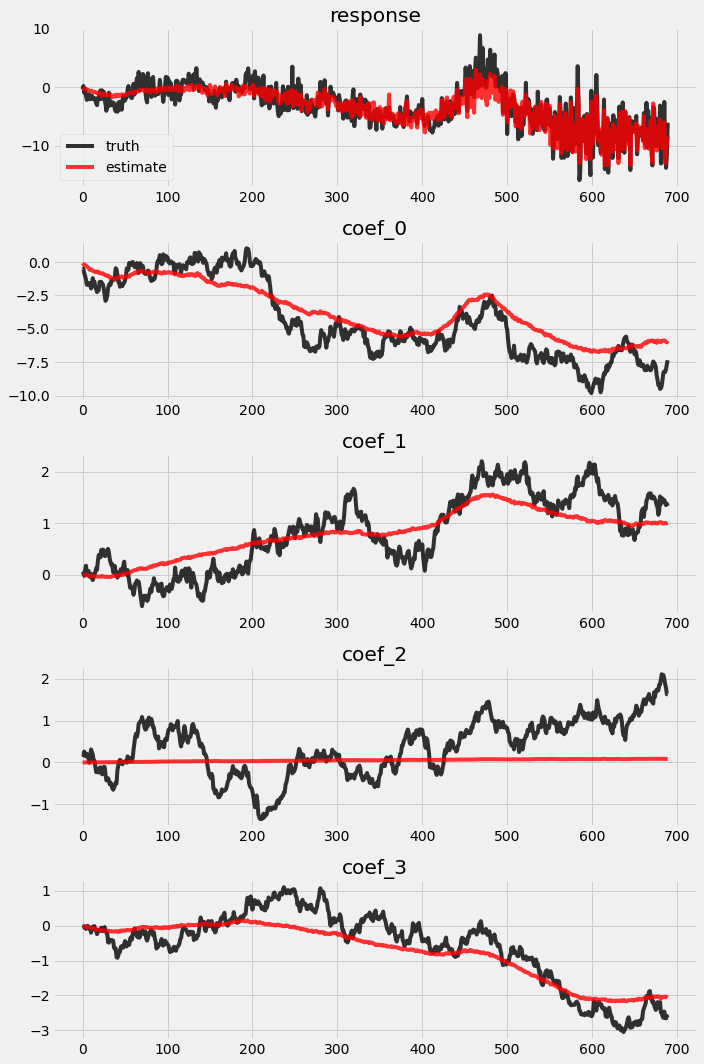

In [8]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8)
        axes[0].plot(prediction, 'r-', label='estimate', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].plot(posterior_weight_mean[:, idx - 1], 'r-', label='estimate', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

### Holdout validation

torch.Size([1000, 30, 1]) torch.Size([30])


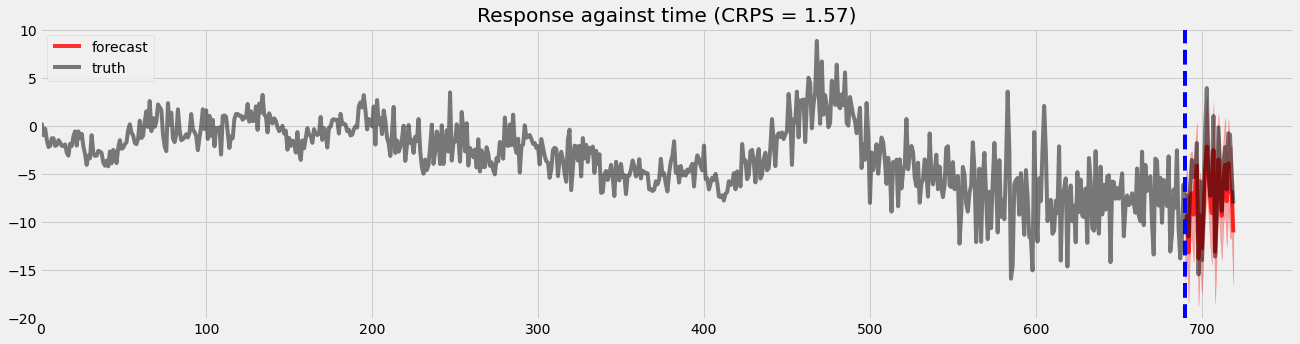

In [9]:
samples = forecaster(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, y[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(y, 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.xlim(0, None)
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

## Train a DLM with coefficients priors at various time points

Sometime user may have prior beliefs of certain coefficients at certain time point. This is especially practical to applications on business where modelers can perform experiments at certain point. In that sense, we should provide an informative prior since experiments usually yield stronger casuality measure. For illustration, we create a simple evenly distributed time points and set priors on those points with the known value $B_t$. Hence, 
$$ \beta_t \sim \mathcal{N}_p(B_t, 0.1)$$ such that $t \in [t_1, t_2, ... t_n]$ and $[t_1, t_2, ... t_n]$ are the time points we have experiential results.

In [10]:
# let's provide some priors
time_points = [100, 200, 300, 400, 500, 600]
# exclude intercept
priors = betas[time_points, 1:]
priors.shape

torch.Size([6, 3])

### Model Training

In [11]:
class DLM2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-5, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight)
        for t, prior in zip(time_points, priors):
            pyro.sample("weight_prior_{}".format(t), dist.Normal(prior, 1e-1).to_event(1), obs=weight[..., t:t+1, 1:]) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-10, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)       

In [12]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
forecaster = Forecaster(DLM2(), y[:T1], covariates[:T1], learning_rate=0.05, num_steps=3000)

INFO 	 step    0 loss = 4.70345e+17
INFO 	 step  100 loss = 2.65483e+10
INFO 	 step  200 loss = 2.93806e+06
INFO 	 step  300 loss = 216.53
INFO 	 step  400 loss = 10.7527
INFO 	 step  500 loss = 7.38382
INFO 	 step  600 loss = 5.09271
INFO 	 step  700 loss = 4.27958
INFO 	 step  800 loss = 3.77899
INFO 	 step  900 loss = 4.39689
INFO 	 step 1000 loss = 3.2571
INFO 	 step 1100 loss = 3.76769
INFO 	 step 1200 loss = 3.88738
INFO 	 step 1300 loss = 3.2668
INFO 	 step 1400 loss = 3.29048
INFO 	 step 1500 loss = 3.01299
INFO 	 step 1600 loss = 3.1312
INFO 	 step 1700 loss = 3.02626
INFO 	 step 1800 loss = 3.2237
INFO 	 step 1900 loss = 8.01036
INFO 	 step 2000 loss = 2.55695
INFO 	 step 2100 loss = 2.8247
INFO 	 step 2200 loss = 3.49704
INFO 	 step 2300 loss = 2.72352
INFO 	 step 2400 loss = 2.82572
INFO 	 step 2500 loss = 2.28832
INFO 	 step 2600 loss = 2.72691
INFO 	 step 2700 loss = 2.77418
INFO 	 step 2800 loss = 2.78764
INFO 	 step 2900 loss = 2.69333


CPU times: user 28 s, sys: 78.1 ms, total: 28.1 s
Wall time: 28.1 s


### Posterior comparison

In [13]:
num_samples = 100
dim = -2
with torch.no_grad():
    # record the VI samples from the guide
    with poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.guide(y[:T1], covariates[:T1])
    guide_trace = tr.trace

    # replay the model against the posteriors samples
    with poutine.replay(trace=guide_trace), poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.model(y[:T1], covariates[:T1])

    # extract the values from the recorded 
    posterior_samples = {
        name: site["value"]
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    }
    
prediction = posterior_samples["prediction"].median(0).values
posterior_weight_mean = posterior_samples['weight'].median(0).values

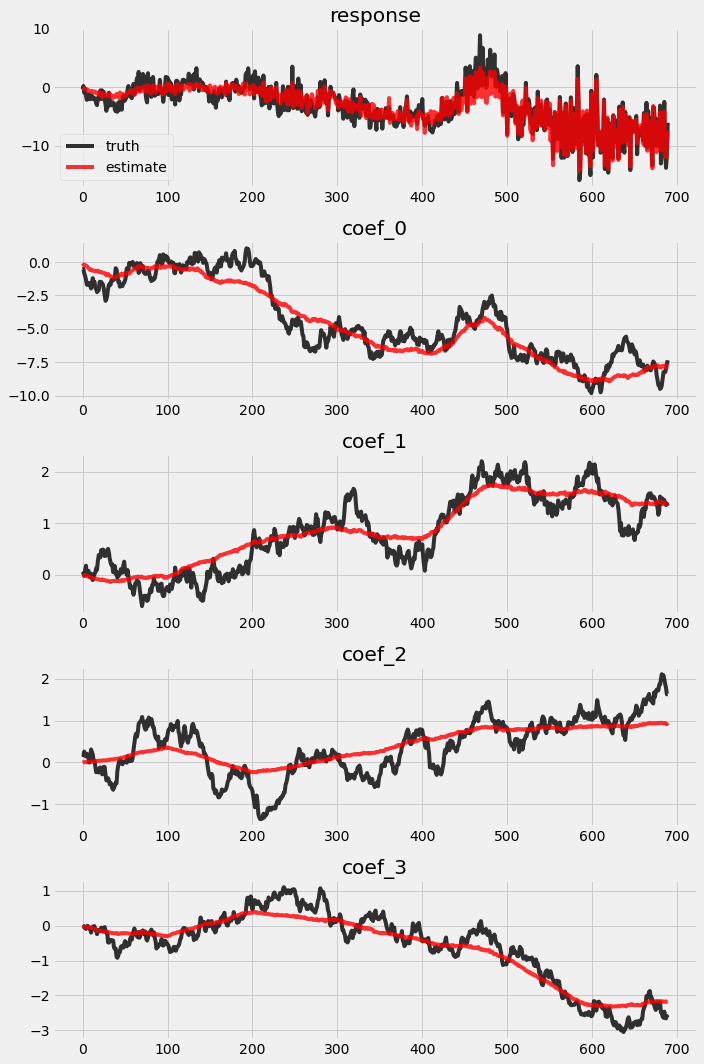

In [14]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8)
        axes[0].plot(prediction, 'r-', label='estimate', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].plot(posterior_weight_mean[:, idx - 1], 'r-', label='estimate', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

### Holdout validation

torch.Size([1000, 30, 1]) torch.Size([30])


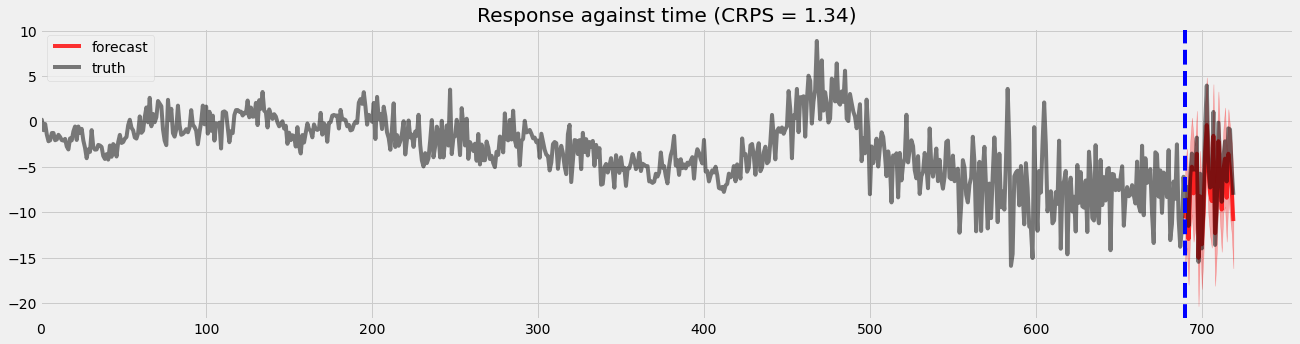

In [15]:
samples = forecaster(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, y[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(y, 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.xlim(0, None)
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

## Conclusion

1. We finish a DLM model in Pyro provides decent forecast with simulated dataset
2. We see a trendmendous improvement on posteriors sampling and out-of-sample prediction CRPS after priors injection.
3. DLM allowing priors injection is practical in modeling business where user can perform experimentations from time to time.

## Reference
- Harvey, C. A. (1989). *Forecasting, Structural Time Series and the Kalman Filter*, Cambridge University Press.
- Durbin, J., Koopman, S. J.. (2001). *Time Series Analysis by State Space Methods*, Oxford Statistical Science Series
- Scott, S. L., and Varian, H. (2015). "Inferring Causal Impact using Bayesian Structural Time-Series Models" The Annals of Applied Statistics, 9(1), 247–274.
- Moore, D., Burnim, J, and the TFP Team (2019). "Structural Time Series modeling in TensorFlow Probability" Available at [https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html)